In [9]:
import cv2
import os 
import glob
import random 
import matplotlib.pyplot as plt
from iou_3d import get_3d_box, box3d_iou, box2d_iou

IMAGE_DIR = "/home/lab530/KenYu/visualDet3D/kitti/training/image_2/"
LABEL_DIR = "/home/lab530/KenYu/visualDet3D/kitti/training/label_2/"
VEHICLES = ["Car"]

# TODO 2D IOU check might make it a good way to do it ? 
# TODO some crop images contain more than one object, will this be a problem?
# TODO if enable multiple objs spawn in sigle image, we need to check if their collide with each other 

class Object:
    def __init__(self, str_line):
        # str_line should be 'Car 0.00 0 -1.58 587.19 178.91 603.38 191.75 1.26 1.60 3.56 -1.53 1.89 73.44 -1.60'
        sl = str_line.split()
        self.category, self.truncated, self.occluded, self.alpha = sl[0], float(sl[1]), int(sl[2]), float(sl[3])
        self.x_min, self.y_min, self.x_max, self.y_max = [int(float(i)) for i in sl[4:8]]
        self.h, self.w, self.l = [float(i) for i in sl[8:11]]
        self.x_3d, self.y_3d, self.z_3d = [float(i) for i in sl[11:14]]
        self.rot_y = float(sl[14])
        self.area = (self.x_max - self.x_min) * (self.y_max - self.y_min)


Find 7481 images.


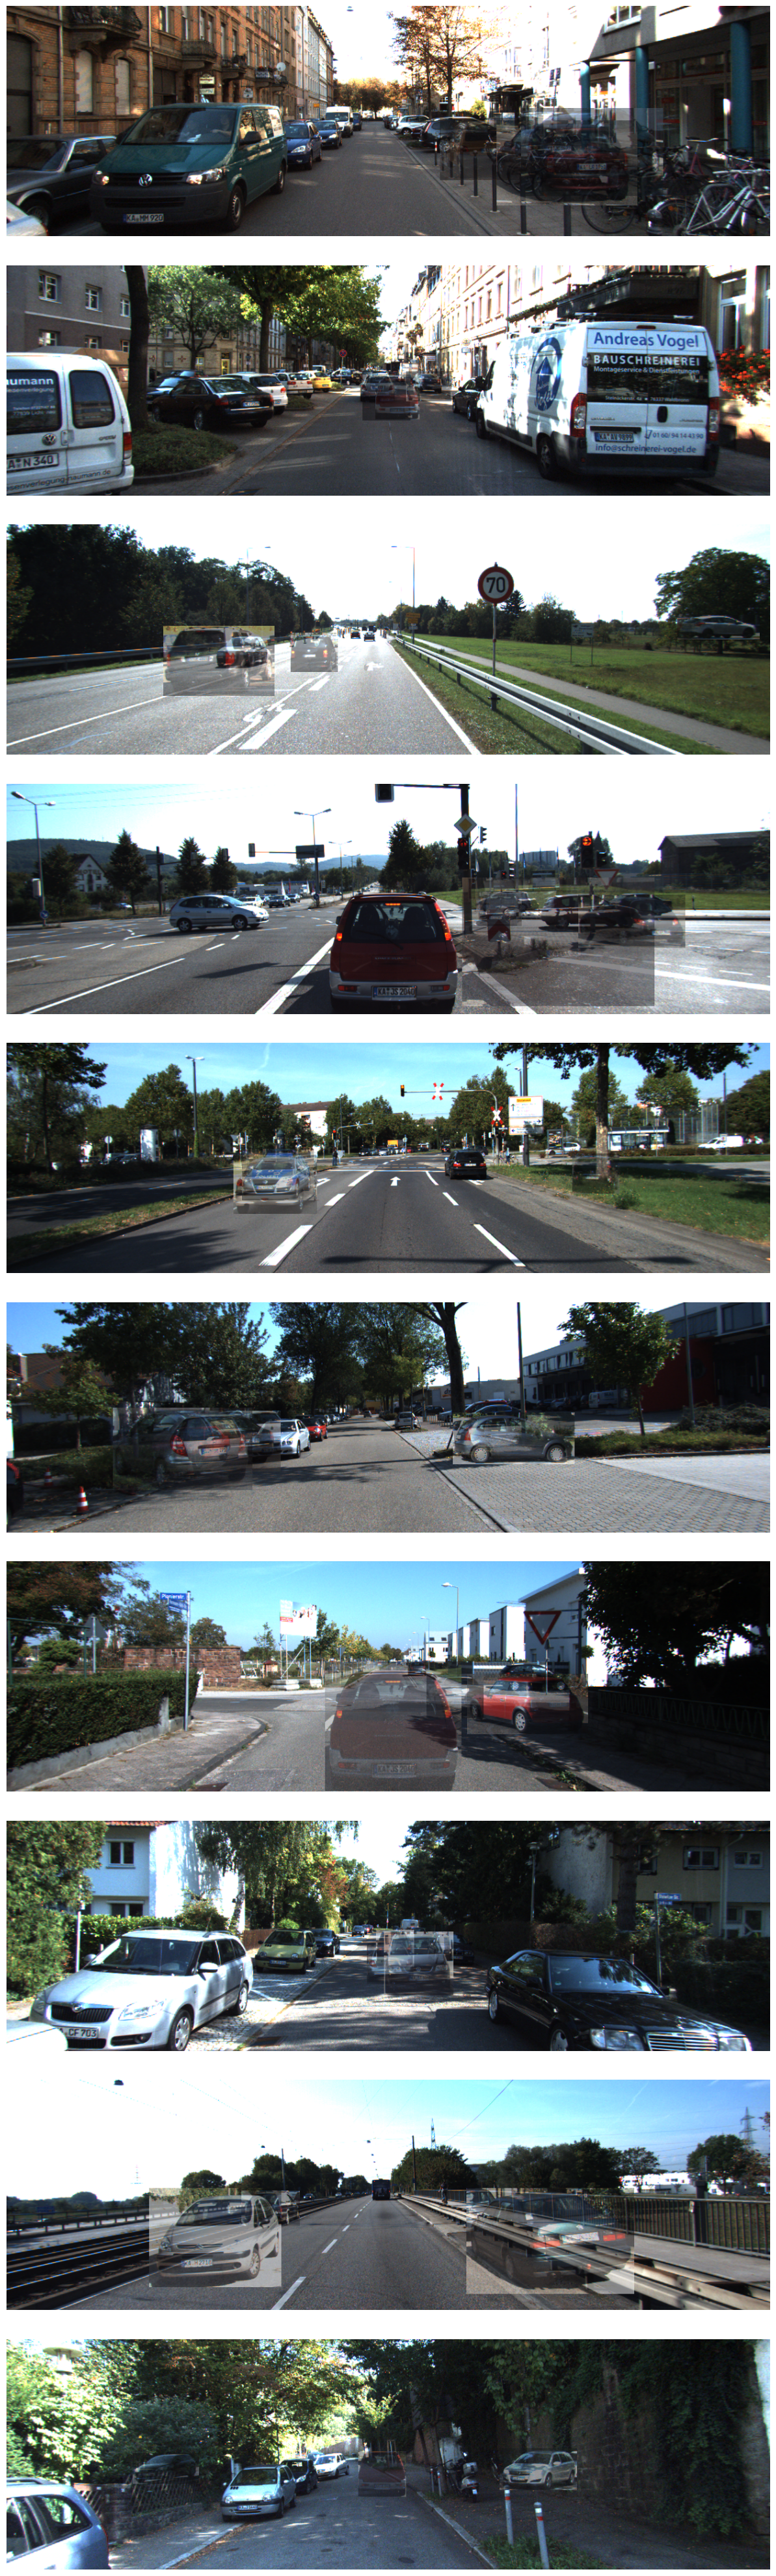

In [10]:
N_OUTPUT = 10
N_ADD_OBJ = 3

img_paths = glob.glob(IMAGE_DIR + "*.png")
N_IMG = len(img_paths)
print(f"Find {N_IMG} images.")

img_aug_list = []
for img_idx in range(N_OUTPUT):
    # Randomly pick one image as augmented image
    ran_aug = random.randint(0, N_IMG-1)
    img_aug = cv2.imread(img_paths[ran_aug])
    
    for obj_idx in range(N_ADD_OBJ): 
        while True:
            # Randomly pick one image as source of new object
            ran_add = random.randint(0, N_IMG-1)
            if ran_aug == ran_add: continue

            # Get aug_object 
            with open(f"{LABEL_DIR}{img_paths[ran_aug].split('/')[-1].split('.')[0]}.txt") as f:
                gt_lines = f.read().splitlines()
                gt_lines = list(gt_lines for gt_lines in gt_lines if gt_lines) # Delete empty lines
                gts_base = [Object(gt) for gt in gt_lines]
            
            # Get add_object
            with open(f"{LABEL_DIR}{img_paths[ran_add].split('/')[-1].split('.')[0]}.txt") as f:
                gt_lines = f.read().splitlines()
                gt_lines = list(gt_lines for gt_lines in gt_lines if gt_lines) # Delete empty lines
                gts_addi_all = [Object(gt) for gt in gt_lines]
            
            # Filter inappropiate objs
            gts_addi = []
            for gt_addi in gts_addi_all:
                if  gt_addi.category in VEHICLES and gt_addi.truncated < 0.5 and gt_addi.occluded == 0.0 and\
                    gt_addi.area > 3000:
                    gts_addi.append(gt_addi)
            if len(gts_addi) == 0: continue
            random.shuffle(gts_addi)

            # Avoid 3D bbox collide with each other on BEV
            max_bev_iou = 0.0
            gdt_add = None
            for gt_addi in gts_addi:
                a_corners = get_3d_box((gt_addi.l, gt_addi.w, gt_addi.h),
                                        gt_addi.rot_y,
                                    (gt_addi.x_3d, gt_addi.y_3d, gt_addi.z_3d))
                
                is_good_spawn = True
                for gt_base in gts_base:
                    b_corners = get_3d_box((gt_base.l, gt_base.w, gt_base.h),
                                            gt_base.rot_y,
                                        (gt_base.x_3d, gt_base.y_3d, gt_base.z_3d))
                    # Get 2D IOU
                    iou_2d = box2d_iou((gt_addi.x_min, gt_addi.y_min, gt_addi.x_max, gt_addi.y_max),
                                    (gt_base.x_min, gt_base.y_min, gt_base.x_max, gt_base.y_max))
                    # Get 3D IOU
                    iou_3db, iou_bev = box3d_iou(a_corners, b_corners)

                    # Avoid far object paste on nearer object
                    if iou_2d > 0.0 and gt_addi.z_3d > gt_base.z_3d: is_good_spawn = False

                    # Avoid 3D bbox collide with each other on BEV
                    if iou_bev > 0.0: is_good_spawn = False
                    #
                    if not is_good_spawn: break
                
                if is_good_spawn: gdt_add = gt_addi
            # 
            if gdt_add != None: break
    
        # Get aug image 
        img_add = cv2.imread(img_paths[ran_add])
        
        # Check if img_aug and img_add has the same resolution
        if img_aug.shape != img_add.shape:
            h_add, w_add, _ = img_add.shape
            h_aug, w_aug, _ = img_aug.shape
            #
            x_min_new = int(gdt_add.x_min * (w_aug/w_add))
            x_max_new = int(gdt_add.x_max * (w_aug/w_add))
            y_min_new = int(gdt_add.y_min * (h_aug/h_add))
            y_max_new = int(gdt_add.y_max * (h_aug/h_add))
            
            # Add new object on augmented image
            roi_add = cv2.resize(img_add[gdt_add.y_min:gdt_add.y_max, gdt_add.x_min:gdt_add.x_max], 
                                (x_max_new - x_min_new, y_max_new - y_min_new)
                                ,interpolation=cv2.INTER_AREA)
            img_aug[y_min_new:y_max_new, x_min_new:x_max_new] = roi_add*0.5 + img_aug[y_min_new:y_max_new, x_min_new:x_max_new]*0.5
        else:
            roi_add = img_add[gdt_add.y_min:gdt_add.y_max, gdt_add.x_min:gdt_add.x_max]
            # Add new object on augmented image
            img_aug[gdt_add.y_min:gdt_add.y_max, gdt_add.x_min:gdt_add.x_max] = roi_add*0.5 + img_aug[gdt_add.y_min:gdt_add.y_max, gdt_add.x_min:gdt_add.x_max]*0.5
    
    img_aug_list.append(img_aug)
# 
fig, ax = plt.subplots(N_OUTPUT, 1, figsize=(20, 40))
fig.set_facecolor('white')
fig.tight_layout()
for img_idx in range(N_OUTPUT):
    ax[img_idx].axis('off')
    ax[img_idx].imshow(img_aug_list[img_idx][...,::-1])

